### FINAL ASSIGNMENT
Case 1 : Chicago Airbnb


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# from pycaret.classification import setup, compare_models, predict_model, save_model, load_model
from sqlalchemy import create_engine
from sklearn.calibration import LabelEncoder

In [3]:
!pip install import-ipynb

In [4]:
import import_ipynb

In [5]:
from udf import prepare_dataframe

Loading the data into dataframe using Pandas

In [6]:
df=pd.read_csv("listings.csv",index_col='id')
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


In [7]:
df.info

<bound method DataFrame.info of                                                        name    host_id  \
id                                                                       
2384      Hyde Park - Walk to UChicago, 10 min to McCormick       2613   
4505      394 Great Reviews. 127 y/o House. 40 yds to tr...       5775   
7126                    Tiny Studio Apartment 94 Walk Score      17928   
9811                          Barbara's Hideaway - Old Town      33004   
10610                      3 Comforts of Cooperative Living       2140   
...                                                     ...        ...   
45514091   Best view of Chicago downtown + optional parking  367907062   
45514389   Luxurious 3Br/2Ba with optional parking and View  367907062   
45514632  Two story Penthouse w private Rooftop & Great ...  367907062   
45515281                             West Town Private Room  347064639   
45515581            Chicago Themed Private Garden Apartment   19541995   

     

Randomly selecting 100 rows as Live Data and saving them into a new CSV file named " Live_data"

In [8]:
live_data = df.sample(n=100, random_state=42)
live_data.to_csv("live_data.csv", index="id")

Removing the live data from the main dataset and saving the remaing into another csv file named "training_data"

In [9]:
df = df.drop(live_data.index)  
df.to_csv("training_data.csv", index=False)

Creating a new database in Postgres to store the remaining data

Firstly providing the credintials for database connection

In [10]:
host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'smooth' 
port = r'5432'
schema = r'raw'

Attempting a database connection

In [11]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

Loading data into Database 

In [12]:
table_name = r'airbnb_data'
schema = r'raw' 

df.to_sql('airbnb_data', db_conn, if_exists='replace', index=False,schema='raw')

297

Screenshot of database in PgAdmin
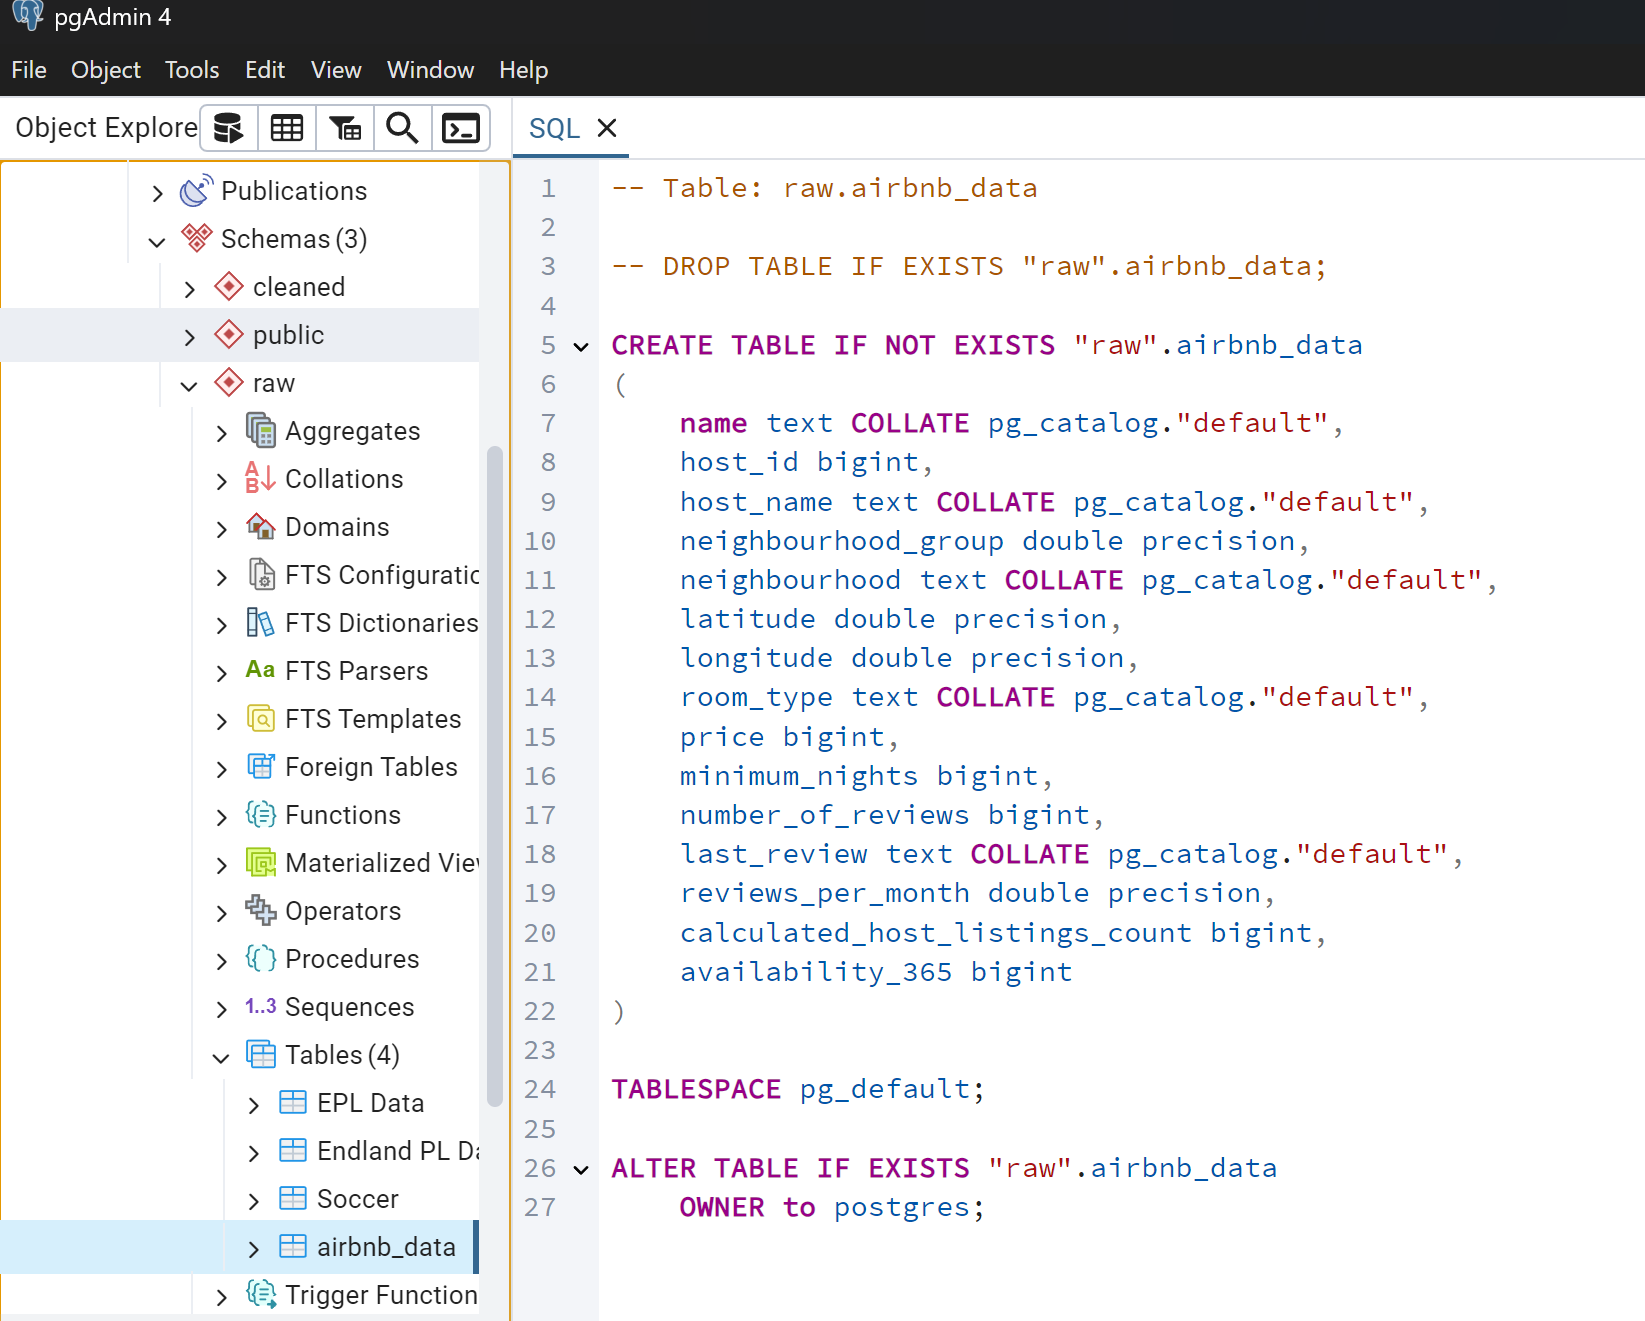

Analytical Question : How can we determine the price per night based on property features?

In [13]:
df.dtypes

name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Handling missing values and outliers

using one hot encoder for categorical columns

In [14]:
# from sklearn.preprocessing import OneHotEncoder

# categorical_cols = df.select_dtypes(include=['object']).columns

# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# print(df.head())  


Since one hot encoder created 8810 columns we are going to use alternative way

Selecting only the required columns

In [15]:
print(df.columns)

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [16]:
def select_features(dataframe):
    dataframe = dataframe[['price', 'room_type', 'neighbourhood','minimum_nights','availability_365']]
    return dataframe
df = select_features(df)    

checking for missing values in our dataset

In [17]:
def check_missing_values(dataframe):
    missing_values = dataframe.isna().sum()
    print(missing_values[missing_values > 0])   


Since there are no missing values we are continuing.

In [18]:
def categorical_col(dataframe):
    categorical_cols = dataframe.select_dtypes(include=['object']).columns
    # print("Categorical Columns:", categorical_cols)
    return categorical_cols

# categorical_cols=categorical_col(df)    

Applying Label encoding to each categorical column. 

The encoders will be stored in a dictionary so that they can be accessed later.

We start from 1 instead of 0 .( since 0 doesnt look nice / personal preference)

Finally we save the encoder for reference.

In [19]:

def save_encoders(categorical_cols):
    import joblib
    label_encoders = {}  
    for col in categorical_cols:
     le = LabelEncoder()
     df[col] = le.fit_transform(df[col]) + 1  
     label_encoders[col] = le  
     joblib.dump(label_encoders, 'label_encoders.pkl')

    

In [20]:
import joblib


def save_encoders(categorical_cols):
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]) + 1  
        label_encoders[col] = le  
    joblib.dump(label_encoders, 'label_encoders.pkl') 
    return df

calling all the functions that I created in the previous cells 

In [ ]:
# def prepare_dataframe_(dataframe):
#     dataframe =  select_features(dataframe)   
#     check_missing_values(dataframe)  
#     categorical_cols=categorical_col(dataframe) 
#     dataframe=save_encoders(categorical_cols)
#     return dataframe
    
 
df=prepare_dataframe(df)   

No missing values found.
Categorical Columns: Index(['room_type', 'neighbourhood'], dtype='object')


In [22]:
df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365
id,,,,,
2384,60,3,34,2,353
4505,105,1,65,2,155
7126,60,1,76,2,321
9811,65,1,39,4,300
10610,21,3,34,1,168


Saving the cleaned data into a new csv file named 'cleaned_listings'

In [23]:
df.to_csv('cleaned_listings.csv',index=False)